<a href="https://www.kaggle.com/code/sanjayrk/customer-churn-prediction-end-to-end-ml-workflow?scriptVersionId=288417575" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# 🧠 Customer Churn: From Data Doubts to Evidence-Based Decisions

# 📌 Project Overview
Predicting customer churn isn't just about high accuracy scores; it’s about understanding human behavior and providing actionable business insights. In this project, I built an end-to-end machine learning pipeline using the Telco Customer Churn dataset to identify high-risk customers.

# 💡 The "Think-First" Approach
Instead of jumping straight into complex models, I approached this as a business problem. 
My journey involved:

Questioning "Perfect" Results: Encountering a 1.0 ROC-AUC and digging deeper to find feature redundancy rather than celebrating a "fake" win.

Feature Engineering with Intent: Fixing data leakage by transforming redundant features into meaningful metrics like AvgCharges.

Model Justification: Defending why a "simple" Logistic Regression model outperformed complex tree-based models on this specific tabular dataset.

# 🛠️ Tech Stack & Workflow
EDA: Automated profiling with ydata-profiling followed by deep-dive manual visualization.
Preprocessing: Scaling, encoding, and addressing multicollinearity.
Modeling: Logistic Regression (L1), Random Forest, XGBoost, and Decision Trees.
Metrics: Prioritizing ROC-AUC and Recall over simple Accuracy to better serve business goals.

In [2]:
df=pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head(3))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   

      PaymentMethod MonthlyCharges  TotalCharges Churn  
0  E

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## 1. Automated EDA using pandas-profiling

In [4]:
!pip install ydata-profiling

In [5]:
from ydata_profiling import ProfileReport
profile=ProfileReport(df,title="Customer Churn Prediction",explorative=True)
profile.to_file("churn_eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 27.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df.drop(columns=["customerID"],inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [8]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


## 2.Manual EDA with numerical features

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    style="ticks",
    palette="muted",
    context="notebook"
)

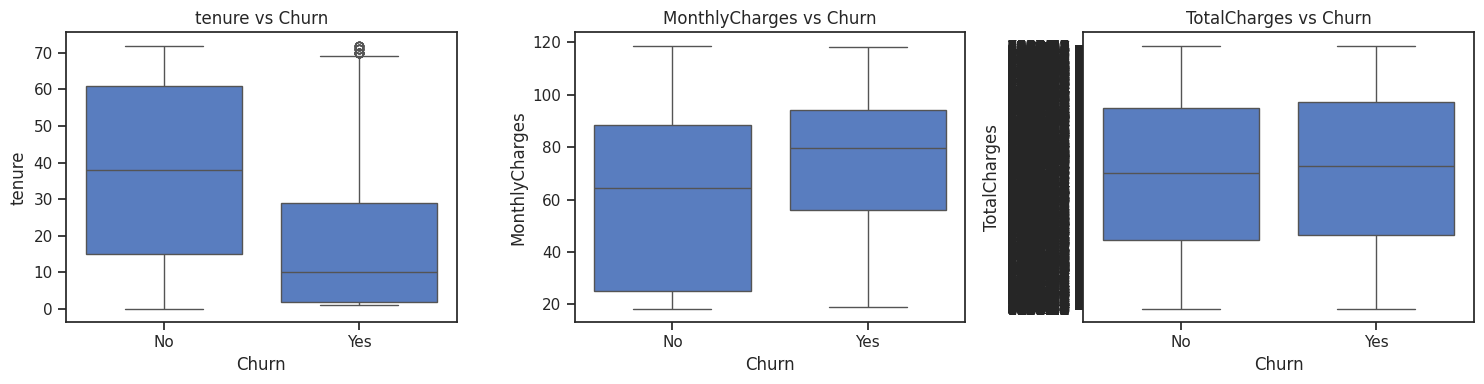

In [10]:
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_features):
    sns.boxplot(x="Churn", y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs Churn")

plt.tight_layout()
plt.show()


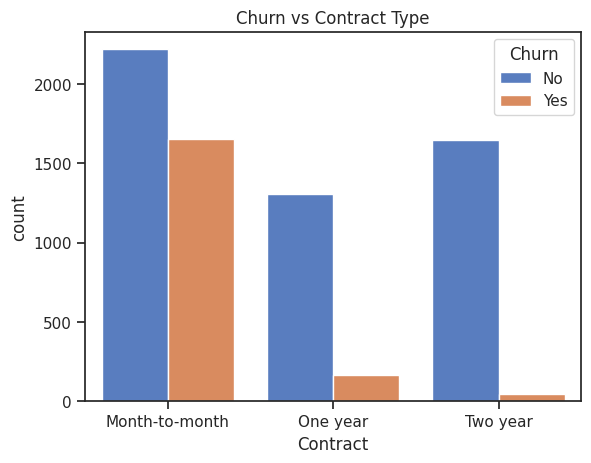

In [11]:
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn vs Contract Type")
plt.show()


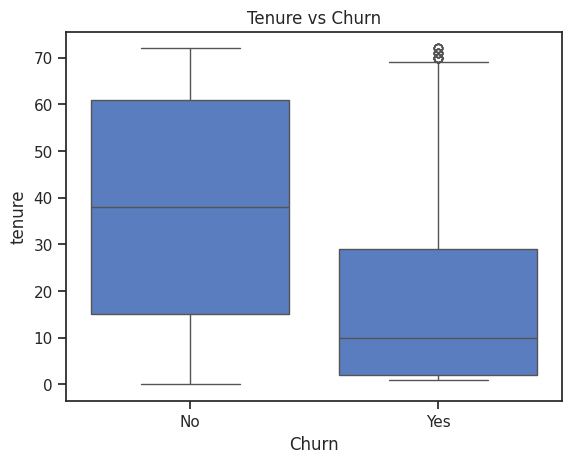

In [12]:
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()


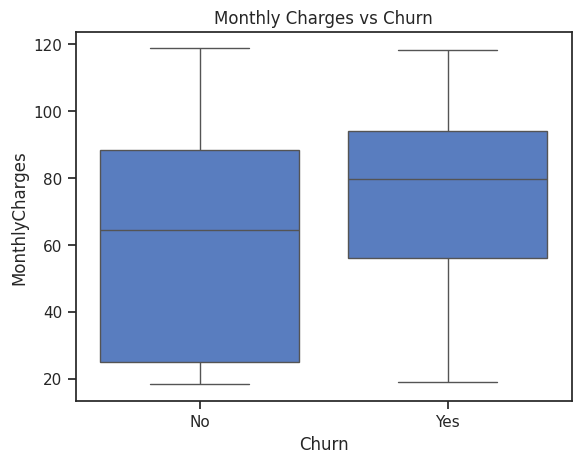

In [13]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


## 3.Feature Engineering

In [14]:
df['TotalCharges']=pd.to_numeric(df["TotalCharges"],errors="coerce")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [16]:
df["TotalCharges"].isna().sum()


np.int64(11)

In [17]:
df.fillna({"TotalCharges":df["TotalCharges"].median()}, inplace=True)


In [18]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [19]:
df["AvgCharges"] = df["TotalCharges"] / (df["tenure"] + 1)
df.drop(columns=["TotalCharges"], inplace=True)
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)



In [20]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

numeric_cols.remove("Churn")


In [21]:
print(categorical_cols)
print(numeric_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'AvgCharges']


## 4.One-hot encoding(Categorical Features)

In [22]:
df_encoded=pd.get_dummies(df,columns=categorical_cols,drop_first=True)
df_encoded.shape

(7043, 31)

In [23]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]


## 5.Importing Scikit-Learn libraries before modeling process

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score,roc_auc_score,f1_score, accuracy_score, classification_report,accuracy_score

## 6.Train-Test Split

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [26]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5634, 30), (1409, 30), (5634,), (1409,))

## 7.Feature Scaling

In [27]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

## 8.Modeling

### 8)a)Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
model_1=LogisticRegression(max_iter=1000,class_weight="balanced",random_state=42)
model_1.fit(X_train_scaled,y_train)

y_pred=model_1.predict(X_test_scaled)
y_pred_proba=model_1.predict_proba(X_test_scaled)[:,1]

In [29]:
accuracy=accuracy_score(y_test,y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
roc_auc=roc_auc_score(y_test,y_pred_proba)

print("ROC_AUC:",roc_auc)



ROC_AUC: 0.844521945800718


In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.77      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



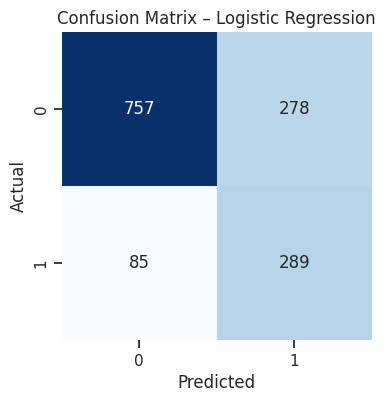

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [32]:
weights = pd.Series(model_1.coef_[0], index=X.columns.values)
print("\n--- Top 10 Features Increasing Churn Risk ---")
print(weights.sort_values(ascending=False).head(10))

print("\n--- Top 10 Features Reducing Churn Risk ---")
print(weights.sort_values(ascending=True).head(10))


--- Top 10 Features Increasing Churn Risk ---
InternetService_Fiber optic       1.042756
StreamingMovies_Yes               0.403091
StreamingTV_Yes                   0.394638
MultipleLines_Yes                 0.292959
PaymentMethod_Electronic check    0.173752
PaperlessBilling_Yes              0.161805
DeviceProtection_Yes              0.129792
PhoneService_Yes                  0.076253
OnlineBackup_Yes                  0.068058
SeniorCitizen                     0.054211
dtype: float64

--- Top 10 Features Reducing Churn Risk ---
AvgCharges                             -2.221612
Contract_Two year                      -0.689607
tenure                                 -0.516465
MonthlyCharges                         -0.430180
Contract_One year                      -0.310259
OnlineBackup_No internet service       -0.110679
OnlineSecurity_No internet service     -0.110679
InternetService_No                     -0.110679
TechSupport_No internet service        -0.110679
DeviceProtection_No in

### 8)b)Logistic Regression with L1 Regularization

In [33]:
model_b = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=0.1,
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

model_b.fit(X_train_scaled, y_train)

y_pred_b = model_b.predict(X_test_scaled)
y_pred_proba_b = model_b.predict_proba(X_test_scaled)[:, 1]

print("=== Model B : L1 Logistic Regression ===")
print(classification_report(y_test, y_pred_b))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_b))

weights_b = pd.Series(model_b.coef_[0], index=X.columns)
print("\n--- Top 10 Features Increasing Churn Risk (Model B) ---")
print(weights_b.sort_values(ascending=False).head(10))

print("\n--- Top 10 Features Reducing Churn Risk (Model B) ---")
print(weights_b.sort_values().head(10))

=== Model B : L1 Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.75      0.76      1409

ROC-AUC: 0.8436100131752307

--- Top 10 Features Increasing Churn Risk (Model B) ---
InternetService_Fiber optic       0.657860
StreamingMovies_Yes               0.235837
StreamingTV_Yes                   0.226564
MultipleLines_Yes                 0.183212
PaymentMethod_Electronic check    0.170090
PaperlessBilling_Yes              0.155666
SeniorCitizen                     0.052896
DeviceProtection_Yes              0.035078
gender_Male                       0.008037
MultipleLines_No phone service    0.007402
dtype: float64

--- Top 10 Features Reducing Churn Risk (Model B) ---
AvgCharges                             -1.16467

In [34]:
from sklearn.feature_selection import RFE

base_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

rfe = RFE(
    estimator=base_model,
    n_features_to_select=15
)

rfe.fit(X_train_scaled, y_train)

selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:")
print(selected_features)

X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

scaler_rfe = StandardScaler()
X_train_rfe_scaled = scaler_rfe.fit_transform(X_train_rfe)
X_test_rfe_scaled = scaler_rfe.transform(X_test_rfe)

model_c = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

model_c.fit(X_train_rfe_scaled, y_train)

y_pred_c = model_c.predict(X_test_rfe_scaled)
y_pred_proba_c = model_c.predict_proba(X_test_rfe_scaled)[:, 1]

print("\n=== Model C : RFE + Logistic Regression ===")
print(classification_report(y_test, y_pred_c))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_c))

weights_c = pd.Series(model_c.coef_[0], index=selected_features)
print("\n--- Top Features Increasing Churn Risk (Model C) ---")
print(weights_c.sort_values(ascending=False).head(10))

print("\n--- Top Features Reducing Churn Risk (Model C) ---")
print(weights_c.sort_values().head(10))


Selected Features by RFE:
Index(['tenure', 'AvgCharges', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check'],
      dtype='object')

=== Model C : RFE + Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409

ROC-AUC: 0.8439807279960734

--- Top Features Increasing Churn Risk (Model C) ---
InternetService_Fiber optic            0.9013

In [35]:
y_train_proba = model_b.predict_proba(X_train_scaled)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_train_proba)
y_test_proba = model_b.predict_proba(X_test_scaled)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print("Train ROC-AUC:", roc_auc_train)
print("Test ROC-AUC :", roc_auc_test)


Train ROC-AUC: 0.8504441397232138
Test ROC-AUC : 0.8436100131752307


### 8)c)Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
model_2 = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    class_weight="balanced",
    random_state=42
)

model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
y_pred_2_proba = model_2.predict_proba(X_test)[:, 1]

roc_auc_2 = roc_auc_score(y_test, y_pred_2_proba)
print("Decision Tree ROC-AUC:", roc_auc_2)

print(classification_report(y_test, y_pred_2))



Decision Tree ROC-AUC: 0.8277584024387092
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409



In [37]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report

dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=100,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_proba = dt.predict_proba(X_test)[:, 1]

print("Decision Tree ROC-AUC:", roc_auc_score(y_test, y_pred_dt_proba))
print(classification_report(y_test, y_pred_dt))


Decision Tree ROC-AUC: 0.8321566044072438
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [40]:
from sklearn.linear_model import LogisticRegression
log_reg_l1 = LogisticRegression(class_weight="balanced",max_iter=1000,penalty="l1",random_state=42,solver="liblinear")

log_reg_l1.fit(X_train_scaled, y_train)
y_pred = log_reg_l1.predict(X_test_scaled)
y_pred_proba = log_reg_l1.predict_proba(X_test_scaled)[:, 1]

print("ROC-AUC(Logistic Regression):", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


ROC-AUC(Logistic Regression): 0.8450567051590069
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300,max_depth=8,min_samples_leaf=50,class_weight="balanced",random_state=42,n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)[:, 1]

print("ROC-AUC (Random Forest):", roc_auc_score(y_test, y_pred_rf_proba))
print("Classification Report(Random Forest):")
print(classification_report(y_test, y_pred_rf))

ROC-AUC (Random Forest): 0.8427936655558139
Classification Report(Random Forest):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



In [42]:
from xgboost import XGBClassifier
xgb=XGBClassifier(n_estimators=400,max_depth=4,learning_rate=0.05,subsample=0.8,colsample_bytree=0.8,eval_metric="logloss",random_state=42)
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]
print("ROC-AUC (XGBoost):", roc_auc_score(y_test, y_pred_xgb_proba))
print("Classification Report(XGBoost):")
print(classification_report(y_test, y_pred_xgb))


ROC-AUC (XGBoost): 0.8397672375933246
Classification Report(XGBoost):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.80      0.79      1409



In [43]:
comparison = pd.DataFrame({
    "Model": [
        "Logistic Regression (L1)",
        "Decision Tree",
        "Random Forest",
        "XGBoost"
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_pred_proba),
        roc_auc_score(y_test, y_pred_dt_proba),
        roc_auc_score(y_test, y_pred_rf_proba),
        roc_auc_score(y_test, y_pred_xgb_proba)
    ]
})

comparison


,Model,ROC-AUC
0,Logistic Regression (L1),0.845057
1,Decision Tree,0.832157
2,Random Forest,0.842794
3,XGBoost,0.839767


***✅ Conclusion & Key Takeaways***

***📊 Model Performance Summary***

All four models were evaluated using ROC-AUC, which is well-suited for churn prediction due to class imbalance and its ability to measure ranking performance across all thresholds.


**🏆 Final Model Selection**

Despite experimenting with advanced tree-based and boosting models, Logistic Regression with L1 regularization achieved the highest ROC-AUC while maintaining strong recall for churn and excellent interpretability.
This indicates that:

* Churn patterns in the dataset are largely linear
* Careful feature engineering and preprocessing captured most of the predictive signal
* Increased model complexity did not yield significant 


**As a result, Logistic Regression was selected as the final model due to its balance of performance, stability, and explainability.**


In [44]:
coef = log_reg_l1.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef
})


idx = np.argmax(y_pred_proba)
customer = X_test.iloc[idx]

contrib_df = coef_df.copy()
contrib_df["value"] = customer.values
contrib_df["contribution"] = contrib_df["value"] * contrib_df["coefficient"]

contrib_df.sort_values("contribution", ascending=False).head(10)


,feature,coefficient,value,contribution
10,InternetService_Fiber optic,0.884162,True,0.884162
23,StreamingMovies_Yes,0.339158,True,0.339158
21,StreamingTV_Yes,0.330219,True,0.330219
9,MultipleLines_Yes,0.260547,True,0.260547
28,PaymentMethod_Electronic check,0.171935,True,0.171935
26,PaperlessBilling_Yes,0.161368,True,0.161368
0,SeniorCitizen,0.053344,1,0.053344
7,PhoneService_Yes,0.051416,True,0.051416
5,Partner_Yes,0.021645,True,0.021645
4,gender_Male,0.018144,True,0.018144


In [45]:
impact_df = coef_df.copy()
impact_df["abs_coef"] = impact_df["coefficient"].abs()

impact_df = impact_df.sort_values("abs_coef", ascending=False)

impact_df.head(10)


,feature,coefficient,abs_coef
3,AvgCharges,-2.297529,2.297529
10,InternetService_Fiber optic,0.884162,0.884162
25,Contract_Two year,-0.690665,0.690665
1,tenure,-0.506180,0.506180
14,OnlineBackup_No internet service,-0.478484,0.478484
23,StreamingMovies_Yes,0.339158,0.339158
21,StreamingTV_Yes,0.330219,0.330219
24,Contract_One year,-0.310444,0.310444
9,MultipleLines_Yes,0.260547,0.260547
28,PaymentMethod_Electronic check,0.171935,0.171935


In [46]:

results_df = X_test.copy()
results_df["churn_probability"] = y_pred_proba

results_df["risk_bucket"] = pd.cut(
    results_df["churn_probability"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low Risk", "Medium Risk", "High Risk"]
)

results_df["risk_bucket"].value_counts()


risk_bucket
Low Risk       606
High Risk      475
Medium Risk    328
Name: count, dtype: int64

In [47]:
high_risk_profile = (
    results_df[results_df["risk_bucket"] == "High Risk"]
    .mean(numeric_only=True)
)

high_risk_profile[["tenure", "AvgCharges"]]




tenure        14.355789
AvgCharges    64.752687
dtype: float64

In [48]:
low_risk_profile = (
    results_df[results_df["risk_bucket"] == "Low Risk"]
    .mean(numeric_only=True)
)

low_risk_profile[["tenure", "AvgCharges"]]


tenure        48.463696
AvgCharges    60.087652
dtype: float64

In [49]:
driver_df = coef_df.copy()
driver_df["abs_coef"] = driver_df["coefficient"].abs()

top_drivers = driver_df.sort_values("abs_coef", ascending=False).head(10)
top_drivers


,feature,coefficient,abs_coef
3,AvgCharges,-2.297529,2.297529
10,InternetService_Fiber optic,0.884162,0.884162
25,Contract_Two year,-0.690665,0.690665
1,tenure,-0.506180,0.506180
14,OnlineBackup_No internet service,-0.478484,0.478484
23,StreamingMovies_Yes,0.339158,0.339158
21,StreamingTV_Yes,0.330219,0.330219
24,Contract_One year,-0.310444,0.310444
9,MultipleLines_Yes,0.260547,0.260547
28,PaymentMethod_Electronic check,0.171935,0.171935


In [50]:
import pandas as pd

insights = pd.DataFrame({
    "Model-Identified Driver": [
        "High Average Monthly Charges",
        "Fiber Optic Internet Service",
        "Two-Year Contract",
        "Customer Tenure",
        "No Internet Service Add-ons",
        "Streaming Services (TV / Movies)",
        "One-Year Contract",
        "Multiple Phone Lines",
        "Electronic Check Payment Method"
    ],
    
    "What the Model Shows": [
        "Customers with higher average charges are less likely to churn, indicating strong loyalty and long-term engagement",
        "Fiber optic users have a significantly higher likelihood of churn",
        "Customers on two-year contracts show substantially lower churn risk",
        "Customers with longer tenure are less likely to churn compared to newer customers",
        "Customers with simpler service usage (no internet add-ons) tend to be more stable",
        "Customers subscribed to streaming add-ons show increased churn risk",
        "One-year contracts reduce churn compared to month-to-month plans",
        "Customers with multiple phone lines exhibit higher churn risk, possibly due to plan complexity",
        "Customers using electronic check payments churn more than those using automated payment methods"
    ],
    
    "Business Recommendation": [
        "Prioritize retention of high-value customers through loyalty rewards and personalized engagement",
        "Improve service quality, proactive support, and targeted retention offers for fiber customers",
        "Incentivize customers to move to long-term contracts using discounts or bundled benefits",
        "Strengthen onboarding, early engagement, and first-month support for new customers",
        "Promote simple and transparent plans to reduce service complexity",
        "Offer flexible or discounted streaming bundles and allow easy opt-in/opt-out options",
        "Encourage migration from month-to-month to annual contracts with moderate incentives",
        "Simplify multi-line plans and provide dedicated support for family or group accounts",
        "Encourage auto-pay or card payments through small incentives and reminders"
    ]
})

insights


,Model-Identified Driver,What the Model Shows,Business Recommendation
0,High Average Monthly Charges,Customers with higher average charges are less...,Prioritize retention of high-value customers t...
1,Fiber Optic Internet Service,Fiber optic users have a significantly higher ...,"Improve service quality, proactive support, an..."
2,Two-Year Contract,Customers on two-year contracts show substanti...,Incentivize customers to move to long-term con...
3,Customer Tenure,Customers with longer tenure are less likely t...,"Strengthen onboarding, early engagement, and f..."
4,No Internet Service Add-ons,Customers with simpler service usage (no inter...,Promote simple and transparent plans to reduce...
5,Streaming Services (TV / Movies),Customers subscribed to streaming add-ons show...,Offer flexible or discounted streaming bundles...
6,One-Year Contract,One-year contracts reduce churn compared to mo...,Encourage migration from month-to-month to ann...
7,Multiple Phone Lines,Customers with multiple phone lines exhibit hi...,Simplify multi-line plans and provide dedicate...
8,Electronic Check Payment Method,Customers using electronic check payments chur...,Encourage auto-pay or card payments through sm...
